# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis based on **the dataset you created from assignment three**.

# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA and LSA. The following information should be reported:

(1) Features (top n-gram phrases) used for topic modeling.

(2) Top 10 clusters for topic modeling.

(3) Summarize and describe the topic for each cluster. 


In [ ]:
# Write your code here
!pip install pyLDAvis 
!pip install ipympl
%matplotlib ipympl
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk

In [ ]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()

In [ ]:
import pandas as pd
reviews = pd.read_csv('reviews_latest.csv',encoding='ISO-8859-1')
reviews

In [ ]:
from nltk.corpus import stopwords
from textblob import TextBlob
reviews['Lower Case'] = reviews['Cleaned_Data'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
reviews['Tokenization'] = reviews['Lower Case'].apply(lambda x: tokenizer.tokenize(x))
reviews['Stemming'] = reviews['Tokenization'].apply(lambda x: [p_stemmer.stem(i) for i in x])

In [ ]:
texts = []
for line in reviews['Stemming']:
  texts.append(line)

In [ ]:
from gensim import corpora, models
bigram = models.Phrases(texts, min_count=5, threshold=100)
trigram = models.Phrases(bigram[texts], threshold=100)
bigram_model = models.phrases.Phraser(bigram)
trigram_model = models.phrases.Phraser(trigram)
print(trigram_model[bigram_model[texts[0]]])

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
import spacy
data_words_bigrams = make_bigrams(texts)
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
lemmatized_data = lemmatization(data_words_bigrams)
print(lemmatized_data[:1])

Preparing Corpus and Dictionary

In [ ]:
id2word = corpora.Dictionary(lemmatized_data)
texts = lemmatized_data
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

In [ ]:
id2word[0]

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

LDA

In [ ]:
lda_model = models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = 20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
from gensim.models import CoherenceModel
print('Perplexity: ', lda_model.log_perplexity(corpus))
lda_coherence_model = CoherenceModel(model=lda_model, texts=lemmatized_data, dictionary=id2word, coherence='c_v')
lda_coherence = lda_coherence_model.get_coherence()
print('Coherence Score: ', lda_coherence)

LSA

In [ ]:
lsamodel = models.LsiModel(corpus, num_topics = 20, id2word = id2word)

In [ ]:
pprint(lsamodel.print_topics(num_topics = 20))

In [ ]:
coherence_values = []
model_list = []
for num_topics in range(2, 12, 1):
  model = models.LsiModel(corpus, num_topics = 20, id2word = id2word)
  model_list.append(model)
  coherence_model = CoherenceModel(model= model, texts = data['Stemming'], dictionary = id2word, coherence='c_v')
  coherence_values.append(coherence_model.get_coherence())

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
values = range(2, 12, 1)
plt.plot(values, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"),loc='best')
plt.show()

In [ ]:
#top 10 clusters
!pip install biterm

from sklearn.feature_extraction.text import TfidfVectorizer
from biterm.btm import oBTM
from biterm.utility import vec_to_biterms, topic_summuary

biterm = reviews['Cleaned_Data'].head(100).values
vector = TfidfVectorizer(stop_words='english')
X_tfidf = vector.fit_transform(biterm).toarray()


text = np.array(vector.get_feature_names())
words = vec_to_biterms(X_tfidf)

model = oBTM(num_topics=10, V=text)
model_lda= model.fit_transform(words, iterations=10)


topic_summuary(model.phi_wz.T, X_tfidf, text, 10)

# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

(1) Features used for sentiment classification and explain why you select these features.

(2) Select two of the supervised learning algorithm from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build a sentiment classifier respectively. 

(3) Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. 

In [ ]:
# Write your code here
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(reviews['Cleaned_Data'])
print(X_tfidf.shape)





In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
mnb = MultinomialNB()
svm = LinearSVC()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_tfidf, reviews['Sentiment'], test_size=0.2, random_state=42)
model_mnb = mnb.fit(x_train,y_train)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred_mnb = model_mnb.predict(x_test)
print('Accuracy {0}'.format(accuracy_score(y_pred_mnb,y_test)))
print(classification_report(y_test,y_pred_mnb))

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(mnb, x_test, y_test, cv=7)
print("using MNB: ",scores.mean())

In [ ]:
model_svm = svm.fit(x_train,y_train)
y_pred_svm = model_svm.predict(x_test)
print('Accuracy {0}'.format(accuracy_score(y_pred_svm,y_test)))
print(classification_report(y_test,y_pred_svm))

In [ ]:
scores = cross_val_score(svm, x_test, y_test, cv=7)
print("using svm: ",scores.mean())

I selected linear svm and multinomial naivee bayes algorithms.

I performed tf-idf as is it balances out the term frequency (how often the word appears in the document) with its inverse document frequency (how often the term appears across all documents in the data set).

This means that words like “a” and “the” will have very low scores as they’ll appear in all documents in your set. Rarer words like for example 'Natural language processing' will be very common in just a handful of documents which talk about text classification. TF-IDF will give higher scores to these words and thus they’ll be the ones that the model identifies as important and tries to learn. Using MNB i got

accuracy: 35 precision recall f1-score support
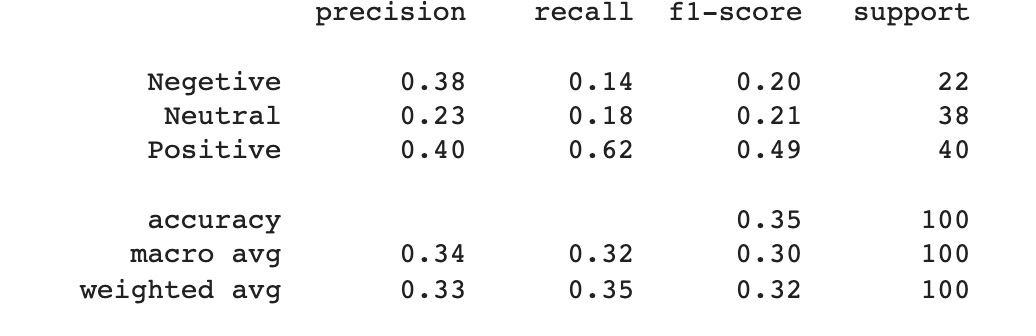

using SVM i got

accuracy: 32 precision recall f1-score support

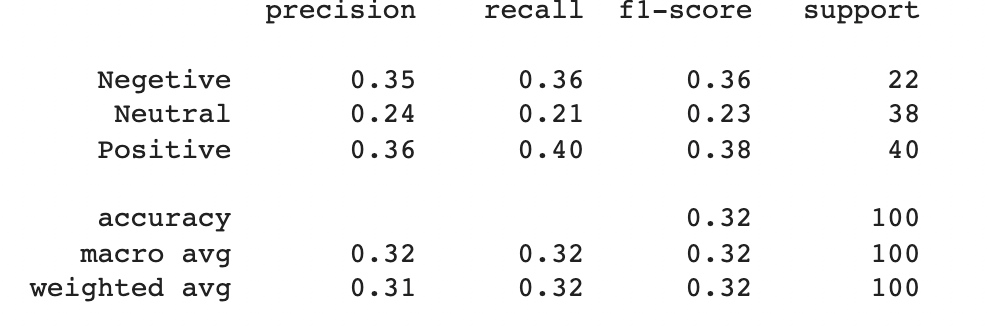

# **Question 3: House price prediction**

(40 points). You are required to build a **regression** model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download here: https://github.com/unt-iialab/info5731_spring2021/blob/main/assignment/assignment4-question3-data.zip. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878. 


In [ ]:
!pip install --user numpy
!pip install --user  pandas

In [ ]:
# Write your code here
import pandas as pd
train = pd.read_csv('test.csv')
validation = pd.read_csv('train.csv')

In [ ]:
train.describe()

In [ ]:
print(train.isnull().sum())

In [ ]:
print(train.isnull().sum())

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [ ]:
corr_mat = train.corr()
corr_mat["YrSold"].sort_values(ascending=False)

In [ ]:
validation.plot(kind="scatter", x="OverallQual", y="SalePrice", alpha=0.5)
validation.plot(kind="scatter", x="GrLivArea", y="SalePrice", alpha=0.5)

In [ ]:
validation.plot(kind="scatter", x="GarageCars", y="SalePrice", alpha=0.5)

In [ ]:
validation.boxplot(column=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea'])

In [ ]:
validation.boxplot(column=['TotalBsmtSF', '1stFlrSF', 'FullBath', 'SalePrice'])

In [ ]:
print(validation.isnull().sum())

In [ ]:
print(train.isnull().sum())

In [ ]:
import numpy as np
train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
train.fillna(999, inplace=True)

Training the Regression Model

In [ ]:
#Train and build the regression model

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder
columns = ('GarageCond', 'LandContour', 'RoofStyle', 'RoofMatl', 'Heating', 'MiscFeature', 'SaleType', 'GarageType', 'Electrical', 'SaleCondition', 'Foundation', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'FireplaceQu', 'LotShape', 'Neighborhood', 'Condition1', 'Condition2', 'Utilities', 'BldgType', 'HouseStyle','PoolQC', 'BsmtQual', 'BsmtCond', 'GarageQual','BsmtExposure', 'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1','BsmtFinType2', 'Functional', 'Fence', 'GarageFinish', 'LandSlope','LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'MSZoning','LotConfig')
for i in columns:
    encoder = LabelEncoder()
    encoder.fit(list(train[i].values))
    train[i] = encoder.transform(list(train[i].values))
for j in columns:
    encoder_test = LabelEncoder()
    encoder_test.fit(list(validation[j].values))
    validation[j] = encoder_test.transform(list(validation[j].values))

x_train = train[train.columns[:80]]
y_train = train['YrSold']
x_validation = validation[validation.columns[:80]]

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)


In [ ]:
import numpy as np
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(999, inplace=True)

Predicting the House Sale Price

In [ ]:
predicted = regressor.predict(x_train)

In [ ]:
pd.DataFrame({'Predicted House Price Values': predicted})